In [4]:
import torch
from diffusers import UNet2DModel, DDPMScheduler
from torchvision import transforms
import PIL.Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import List


sample_to_pil = transforms.Compose([
        transforms.Lambda(lambda t: t.squeeze(0)), # CHW to HWC
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: (t + 1) * 127.5), # [-1, 1] to [0, 255]
        transforms.Lambda(lambda t: torch.clamp(t, 0, 255)),
        transforms.Lambda(lambda t: t.cpu().detach().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])


class RePaintScheduler:
    def __init__(self, ddpm_scheduler: DDPMScheduler, resample_steps: int = 10, jump_length: int = 10):
        self.ddpm = ddpm_scheduler
        self.resample_steps = resample_steps
        self.jump_length = jump_length
        self.timesteps = list(range(ddpm_scheduler.num_train_timesteps - 1, -1, -1))

    def q_sample_known(self, x0: torch.Tensor, t: int) -> torch.Tensor:
        alpha_bar = self.ddpm.alphas_cumprod[t].clamp(min=1e-5)
        noise = torch.randn_like(x0)
        return (alpha_bar.sqrt() * x0) + ((1 - alpha_bar).sqrt() * noise)

    def reverse_denoise(self, x_t: torch.Tensor, t: int, unet: UNet2DModel) -> torch.Tensor:
        beta_t = self.ddpm.betas[t]
        alpha_t = self.ddpm.alphas[t]
        alpha_bar = self.ddpm.alphas_cumprod[t].clamp(min=1e-5)

        eps_pred = unet(x_t, t).sample
        mu = (1.0 / alpha_t.sqrt()) * (x_t - ((beta_t / (1 - alpha_bar).sqrt()) * eps_pred))

        if t > 0:
            return mu + beta_t.sqrt() * torch.randn_like(x_t)
        return mu

    def forward_jump(self, x_prev: torch.Tensor, t: int) -> torch.Tensor:
        t_next = max(t - self.jump_length, 0)
        alpha_bar = self.ddpm.alphas_cumprod[t].clamp(min=1e-5)
        alpha_bar_next = self.ddpm.alphas_cumprod[t_next].clamp(min=1e-5)
        ratio = (alpha_bar_next / alpha_bar).clamp(min=1e-5, max=1.0)
        noise = torch.randn_like(x_prev)
        return ratio.sqrt() * x_prev + (1 - ratio).sqrt() * noise


@torch.no_grad()
def repaint(
    unet: UNet2DModel,
    scheduler: RePaintScheduler,
    x0: torch.Tensor,
    mask: torch.Tensor
) -> torch.Tensor:
    """
    RePaint inpainting driver.
    Args:
      unet: pretrained UNet2DModel for noise prediction.
      scheduler: configured RePaintScheduler instance.
      x0: original image [-1,1], shape [B,C,H,W].
      mask: binary mask (1=inpaint, 0=keep), same shape.
    Returns:
      Inpainted image tensor.
    """
    device = x0.device
    x = torch.randn_like(x0).to(device)  # start from noise

    for t in tqdm(scheduler.timesteps, desc="RePaint"):
        for u in range(scheduler.resample_steps):
            x_known = scheduler.q_sample_known(x0, t)
            x_unknown = scheduler.reverse_denoise(x, t, unet)

            x = mask * x_known + (1 - mask) * x_unknown
            if u < scheduler.resample_steps - 1:
                x = scheduler.forward_jump(x, t)

        if t % 100 == 0:
            print("saving intermediate result")
            result = x
            result = result.squeeze(0).cpu()
            result = (result + 1) / 2
            result = transforms.ToPILImage()(result.clamp(0, 1))
            result.save(f"result_{t}.png")

    return x


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_id = "google/ddpm-celebahq-256"

    T = 25
    betas = torch.linspace(1e-4, 0.02, T)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to(device).eval()
    ddpm_scheduler = DDPMScheduler.from_pretrained(model_id)
    scheduler = RePaintScheduler(
        ddpm_scheduler=ddpm_scheduler,
        resample_steps=10,
        jump_length=5,
    )


    data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
        transforms.Lambda(lambda t: t.unsqueeze(0))
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t.unsqueeze(0))
    ])

    image = PIL.Image.open("celeba_00.jpg")
    mask = PIL.Image.open("half_mask.png")
    image = data_transform(image).to(device)
    mask = mask_transform(mask).to(device)

    with torch.no_grad():
      result = repaint(model, scheduler, image, mask)

    print("result.min():", result.min().item(), "result.max():", result.max().item())

    result = result.squeeze(0).cpu()
    result = (result + 1) / 2
    result = transforms.ToPILImage()(result.clamp(0, 1))
    result.save("result.png")

    plt.imshow(result)
    plt.show()




An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
RePaint:  10%|█         | 100/1000 [02:01<18:58,  1.26s/it]

saving intermediate result


RePaint:  20%|██        | 200/1000 [04:05<16:54,  1.27s/it]

saving intermediate result


RePaint:  26%|██▌       | 258/1000 [05:17<15:13,  1.23s/it]


KeyboardInterrupt: 

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


beginning repaint


100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


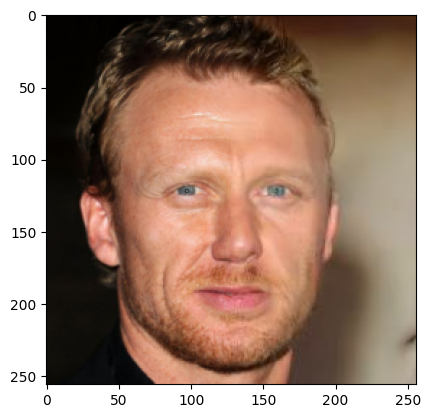